In [ ]:
import ember
X_train, y_train, X_test, y_test = ember.read_vectorized_features("drive/MyDrive/Colab Notebooks/AISec/vMalConv/")


In [ ]:


# Filter out rows with label -1
labelrows = (y_train != -1)
X_train = X_train[labelrows]
y_train = y_train[labelrows]



In [ ]:
from sklearn.model_selection import train_test_split

#Stratifying
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=42)
_, X_test, _, y_test = train_test_split(X_test, y_test, test_size=0.8, stratify=y_test, random_state=42)

In [ ]:
import pickle



# Save training data
with open("X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

# Save testing data
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Data saved successfully!")


## Loading the pickled dataset
> Already preprocced to save the loading time

In [ ]:
import pickle

# Define the directory path (replace with your actual path)
data_dir = "/content/drive/MyDrive/Colab Notebooks/AISec/vMalConv"  # Assuming Colab environment

# Load training data
try:
    with open(f"{data_dir}/X_train.pkl", "rb") as f:
        X_train = pickle.load(f)

    with open(f"{data_dir}/y_train.pkl", "rb") as f:
        y_train = pickle.load(f)
except FileNotFoundError:
    print("Training data pickle files not found. Please ensure they exist in the specified directory.")

# Load testing data
try:
    with open(f"{data_dir}/X_test.pkl", "rb") as f:
        X_test = pickle.load(f)

    with open(f"{data_dir}/y_test.pkl", "rb") as f:
        y_test = pickle.load(f)
except FileNotFoundError:
    print("Testing data pickle files not found. Please ensure they exist in the specified directory.")

print("Data loaded successfully!")


### Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

mms = StandardScaler()
range_end = X_train.shape[0]
range_step =  1000

for x in range(0, range_end, range_step):
  mms.partial_fit(X_train[x:x+range_step])


In [ ]:
X_train = mms.transform(X_train)

In [ ]:
# Find the minimum value in the scaled data
min_val = X_train.min()

# Shift the data if the minimum value is less than 0
if min_val < 0:
    # We add a bit more to ensure there are no values at exactly 0, if desired
    shift_value = np.abs(min_val) # For example, ensuring the min value is at least 1
    X_train = X_train + shift_value



In [ ]:
from sklearn.preprocessing import StandardScaler

mms = StandardScaler()
range_end = X_test.shape[0]
range_step =  1000

for x in range(0, range_end, range_step):
  mms.partial_fit(X_test[x:x+range_step])


In [ ]:
X_test = mms.transform(X_test)

In [ ]:
# Find the minimum value in the scaled data
min_val = X_test.min()

# Shift the data if the minimum value is less than 0
if min_val < 0:
    # We add a bit more to ensure there are no values at exactly 0, if desired
    shift_value = np.abs(min_val)   # For example, ensuring the min value is at least 1
    X_test = X_test + shift_value



### Tensorizing

In [ ]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Convert your numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Split the data into training and validation sets (80% training, 20% validation)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoaders for training and validation sets
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val_split, y_val_split)

batch_size = 4000  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MalConv(nn.Module):
    def __init__(self, input_length=2000000, embedding_dim=8, window_size=500, output_dim=1):
        super(MalConv, self).__init__()
        self.embed = nn.Embedding(input_length, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=window_size, stride=window_size, padding=0)
        self.conv2 = nn.Conv1d(embedding_dim, 128, kernel_size=window_size, stride=window_size, padding=0)
        self.gating = nn.Sigmoid()
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embed(x)
        x = x.transpose(1, 2)  # Convert to (batch_size, channels, length)
        conv1 = self.conv1(x)
        conv2 = self.conv2(x)
        gated = conv1 * self.gating(conv2)  # Element-wise multiplication
        global_max_pool = self.global_max_pool(gated).squeeze(2)  # Remove the last dimension
        fc1 = F.relu(self.fc1(global_max_pool))
        fc2 = self.fc2(fc1)
        output = self.sigmoid(fc2)
        return output

# Example of creating and testing a MalConv model

model = MalConv()
print(model)



## Training

Epoch 1, Training Loss: 0.5288458958268165, Validation Loss: 0.3720565468072891
Epoch 2, Training Loss: 0.30224362164735796, Validation Loss: 0.309660530090332
Epoch 3, Training Loss: 0.23184595331549646, Validation Loss: 0.24522048234939575
Epoch 4, Training Loss: 0.18159339874982833, Validation Loss: 0.2526845961809158
Epoch 5, Training Loss: 0.14387257527559996, Validation Loss: 0.24575320184230803
Model checkpoint saved to drive/MyDrive/Colab Notebooks/AISec/vMalConv/model_epoch_5.pt
Epoch 6, Training Loss: 0.09429372232407332, Validation Loss: 0.2684519052505493
Epoch 7, Training Loss: 0.057155044935643676, Validation Loss: 0.30032658874988555
Epoch 8, Training Loss: 0.026906533213332296, Validation Loss: 0.3392070889472961
Epoch 9, Training Loss: 0.011149972956627608, Validation Loss: 0.3902670592069626
Epoch 10, Training Loss: 0.0045138717512600126, Validation Loss: 0.42569802701473236
Model checkpoint saved to drive/MyDrive/Colab Notebooks/AISec/vMalConv/model_epoch_10.pt
Epoch

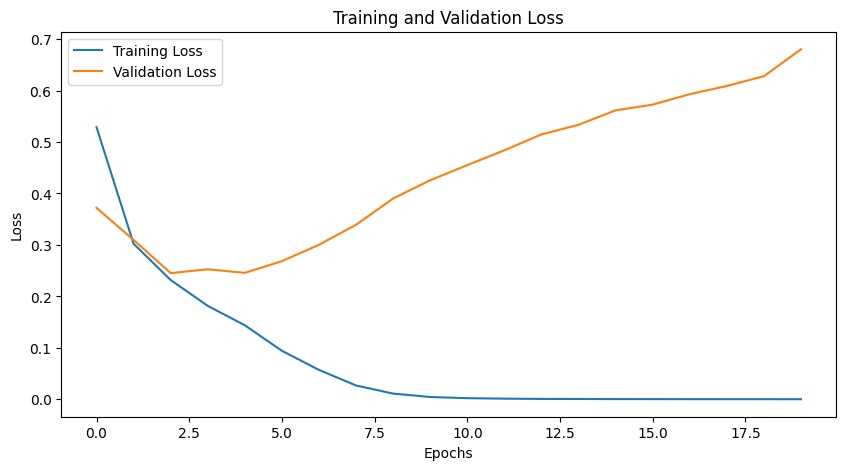

In [ ]:

import torch
import torch.optim as optim
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

# Assuming MalConv is defined as before
model = MalConv()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Directory to save model checkpoints
save_dir = "drive/MyDrive/Colab Notebooks/AISec/vMalConv"
os.makedirs(save_dir, exist_ok=True)

# Training Loop with Validation
num_epochs = 20  # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()

    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {epoch_loss}, Validation Loss: {epoch_val_loss}')

    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)
        print(f'Model checkpoint saved to {checkpoint_path}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Test

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure the model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lists to store model predictions and actual labels
predictions = []
labels_list = []  # Renamed to avoid confusion with the loop variable

with torch.no_grad():
    for inputs, labels_batch in test_loader:
        inputs = inputs.to(device)  # Move inputs to the same device as model
        outputs = model(inputs)
        predicted = torch.round(outputs.squeeze())  # Convert probabilities to binary predictions (0 or 1)

        # Store predictions and labels
        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels_batch.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(labels_list, predictions)
precision = precision_score(labels_list, predictions)
recall = recall_score(labels_list, predictions)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Test Accuracy: 0.6817
Precision: 0.8102
Recall: 0.4747


## Save the model

In [ ]:
# Save the model parameters
model_weights_path = os.path.join(save_dir, "model_weights.pt")
torch.save(model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

# Save a checkpoint including model state, optimizer state, and other info
checkpoint_path = os.path.join(save_dir, "model_final_checkpoint.pt")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'last_loss': loss.item(),
    # Include any other information you need
}, checkpoint_path)

print(f"Full model checkpoint saved to {checkpoint_path}")



Model weights saved to drive/MyDrive/Colab Notebooks/AISec/vMalConv/model_weights.pt
Full model checkpoint saved to drive/MyDrive/Colab Notebooks/AISec/vMalConv/model_final_checkpoint.pt


## Deployment
> Unsuccessful!

In [ ]:
# import boto3

# # Initialize AWS credentials and region if needed
# boto3.setup_default_session(region_name='US East (N. Virginia) us-east-1', aws_access_key_id='your-access-key', aws_secret_access_key='your-secret-access-key')

# bucket_name = 'sagemaker-deploy-aisec-midterm'
# key = 'model/'
# file_path = os.path.join(save_dir, "model_final_checkpoint.pt")
# url = 's3://{}/{}'.format(bucket_name, key)

# s3_client = boto3.client('s3')
# s3_client.upload_file(file_path, bucket_name, key + 'model_final_checkpoint.pt')

# print("Model uploaded successfully to S3 bucket:", url)



# Result

During the training process, it was observed that the model started to overgeneralize after epoch 3, as indicated by an increase in validation loss. This phenomenon occurred consistently across different methods of scaling and sample sizes. However, the decision was made to retain this checkpoint as the final one since it was trained with the most data available.

The overgeneralization may be attributed to the functioning of the embedding layer and the feature engineering process. It is likely influenced by a partial understanding of the Ember dataset and the nuances of the embedding layer.

Despite encountering challenges during training, the test accuracy was deemed satisfactory. To achieve this result, the scale of the test dataset was adjusted by standardizing it.



*In the deployment phase, significant time was invested, but unfortunately, it was ultimately unsuccessful. This could potentially be attributed to limitations imposed by the student account (AWS free tier), which restricts access to certain credentials necessary for deployment. Additionally, the lack of success may also stem from limitations in knowledge and expertise.*

*The deployment failure highlights the importance of considering account restrictions and technical limitations when attempting to deploy models in real-world scenarios.*
